In [ ]:
! pip install opendatasets --upgrade --quiet
! pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import pandas as pd
import os
import opendatasets as od

In [ ]:
from PIL import Image
import numpy as np
import tqdm
import cv2
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/c/11-785-fall-20-homework-2-part-2'
# Using opendatasets let's download the data sets
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: satoutakara
Your Kaggle Key: ··········


100%|██████████| 1.35G/1.35G [01:08<00:00, 21.1MB/s]



Extracting archive ./11-785-fall-20-homework-2-part-2/11-785-fall-20-homework-2-part-2.zip to ./11-785-fall-20-homework-2-part-2


In [ ]:
target_shape = (300, 300)
num_classes = 4000
BATCH_SIZE = 32

In [ ]:
base_path = '/content/11-785-fall-20-homework-2-part-2/classification_data/'
train_path = os.path.join(base_path, 'train_data')
val_path = os.path.join(base_path, 'val_data')
test_path = os.path.join(base_path, 'test_data')
base_path_ver = '/content/11-785-fall-20-homework-2-part-2/'
ver_file_path = os.path.join('/content/11-785-fall-20-homework-2-part-2/verification_pairs_val.txt')

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    seed=2023,
    image_size=target_shape,
    batch_size=64
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size=target_shape,
    batch_size=64
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=target_shape,
    batch_size=64
)

Found 380638 files belonging to 4000 classes.
Found 8000 files belonging to 4000 classes.
Found 8000 files belonging to 4000 classes.


In [ ]:
def preprocess_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

def preprocess_image_file(file_path):
    image_string = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    return preprocess_image(image)

def preprocess_image_pair(pair, label):
    image1 = preprocess_image_file(pair[0])
    image2 = preprocess_image_file(pair[1])
    return (image1, image2), label

def load_verification_data(file_path, image_dir, batch_size):
    pairs = []
    labels = []

    with open(file_path, 'r') as f:
        for line in f:
            pair = line.strip().split()
            pairs.append((os.path.join(image_dir, pair[0]), os.path.join(image_dir, pair[1])))
            labels.append(float(pair[2]))

    dataset = tf.data.Dataset.from_tensor_slices((pairs, labels))
    dataset = dataset.map(preprocess_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
ver_dataset = load_verification_data(ver_file_path, base_path_ver, 64)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import xception
from tensorflow.keras import layers, Model

# Add a rescaling layer
rescale = layers.Rescaling(1./255, input_shape=target_shape + (3,))

# Define the input for the embedding model
input_image = layers.Input(shape=target_shape + (3,), name="input_image")

# Add rescaling layer
rescaled_input = rescale(input_image)

# Define the base model using Xception with rescaled input
base_cnn = xception.Xception(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
    # , pooling="avg"
)

# Pass rescaled input through the base model
base_output = base_cnn(rescaled_input)

flatten = layers.Flatten()(base_output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output_dense = layers.Dense(256)(dense2)

# Define the embedding model
embedding = Model(input_image, output_dense, name="Embedding")

# Set all layers of base_cnn to be trainable
for layer in base_cnn.layers:
    layer.trainable = True

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
from tensorflow.keras.applications import resnet
from tensorflow.keras import layers, models

output = layers.Dense(num_classes, activation='softmax')(embedding.output)

# Create the complete classification model
classification_model = Model(inputs=embedding.input, outputs=output, name="ClassificationModel")

In [ ]:
classification_model.summary()

Model: "ClassificationModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     104,858,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4000)                │       1,028,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,947,784 (484.27 MB)

 Trainable params: 126,891,720 (484.05 MB)

 Non-trainable params: 56,064 (219.00 KB)

In [ ]:
# Compile the model with an initial learning rate and metrics
classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Example training code
history = classification_model.fit(
    train_dataset,           # Your training dataset
    epochs=4,               # Number of epochs
    validation_data=val_dataset,  # Your validation dataset
)

Epoch 1/10
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 1177s 186ms/step - loss: 6.2710 - sparse_categorical_accuracy: 0.0556 - val_loss: 3.7844 - val_sparse_categorical_accuracy: 0.2639
Epoch 2/10
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 1071s 180ms/step - loss: 2.7256 - sparse_categorical_accuracy: 0.4223 - val_loss: 2.3441 - val_sparse_categorical_accuracy: 0.5099
Epoch 3/10
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 1071s 180ms/step - loss: 1.6536 - sparse_categorical_accuracy: 0.6272 - val_loss: 1.9478 - val_sparse_categorical_accuracy: 0.5946
Epoch 4/10
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 1071s 180ms/step - loss: 1.1561 - sparse_categorical_accuracy: 0.7274 - val_loss: 1.8884 - val_sparse_categorical_accuracy: 0.6215
Epoch 5/10
 306/5948 ━━━━━━━━━━━━━━━━━━━━ 16:52 179ms/step - loss: 0.9343 - sparse_categorical_accuracy: 0.7725

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test dataset (if you have one)
test_loss, test_accuracy = classification_model.evaluate(test_dataset)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 2.0451 - sparse_categorical_accuracy: 0.5877
Test loss: 2.055091381072998
Test accuracy: 0.5911250114440918


In [ ]:
# Save the embedding model
embedding.save('embedding_xception_no_pooling.h5')  # or 'embedding_model' for SavedModel format

In [ ]:
import shutil

# Define the path to the saved model and the destination path in Google Drive
model_path = 'embedding_xception_no_pooling.h5'  # or 'siamese_model.h5'
drive_path = '/content/drive/My Drive/Applied ML/project/embedding_xception_no_pooling.h5'  # or 'siamese_model.h5'

# Ensure the destination directory exists
import os
os.makedirs(os.path.dirname(drive_path), exist_ok=True)

# Move the model file to Google Drive
shutil.move(model_path, drive_path)

'/content/drive/My Drive/Applied ML/project/embedding_xception_no_pooling.h5'

In [ ]:
from tensorflow.keras.models import load_model

# Define the path to your model file
model_path = '/content/drive/My Drive/Applied ML/project/embedding_xception_no_pooling.h5'

# Load the model
embedding = load_model(model_path)

# siamese_network = siamese_model.siamese_network

# Verify the model loaded correctly by printing its summary
embedding.summary()

Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     104,858,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,919,784 (480.35 MB)

 Trainable params: 125,863,720 (480.13 MB)

 Non-trainable params: 56,064 (219.00 KB)

In [ ]:
# Define the PairDistanceLayer and create the pair_model
class PairDistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, image1, image2):
        distance = 1 - ops.sum(tf.square(image1 - image2), -1)
        return distance

In [ ]:
# Define the input layers
image1_input = layers.Input(name="image1", shape=target_shape + (3,))
image2_input = layers.Input(name="image2", shape=target_shape + (3,))

# Assuming 'embedding' and 'resnet' are defined elsewhere
embedding1 = embedding(image1_input)
embedding2 = embedding(image2_input)

# Apply the PairDistanceLayer
similarity_scores = PairDistanceLayer()(
    image1=embedding1,
    image2=embedding2
)

# Create the model
pair_model = Model(inputs=[image1_input, image2_input], outputs=similarity_scores)

In [ ]:
pair_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer)       │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image2 (InputLayer)       │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Embedding (Functional)    │ (None, 256)            │    125,919,784 │ image1[0][0],          │
│                           │                        │                │ image2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pair_distance_layer_1     │ (None)                 │              0 │ Embedding[0][0],       │
│ (PairDistanceLayer)       │                        │                │ Embedding[1][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 125,919,784 (480.35 MB)

 Trainable params: 125,863,720 (480.13 MB)

 Non-trainable params: 56,064 (219.00 KB)

In [ ]:
# Function to compute similarity scores and normalize them
def compute_similarity_scores(pair_model, ver_dataset):
    similarity_scores = []
    true_labels = []
    for (image1, image2), label in ver_dataset:
        similarity_score = pair_model.predict([image1, image2])
        similarity_scores.append(similarity_score)
        true_labels.append(label.numpy())

    similarity_scores = np.concatenate(similarity_scores)
    true_labels = np.concatenate(true_labels)

    return similarity_scores, true_labels

# Assuming 'ver_dataset' is the test dataset obtained from load_val_verification_data
similarity_scores, true_labels = compute_similarity_scores(pair_model, ver_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━

In [ ]:
import numpy as np

# Assuming array is your NumPy array
array = similarity_scores

# Calculate statistics
mean_value = np.mean(array)
std_dev = np.std(array)
min_value = np.min(array)
max_value = np.max(array)
median_value = np.median(array)
percentile_25 = np.percentile(array, 25)
percentile_75 = np.percentile(array, 75)

# Print statistics
print("Mean:", mean_value)
print("Standard Deviation:", std_dev)
print("Minimum:", min_value)
print("Maximum:", max_value)
print("Median:", median_value)
print("25th Percentile:", percentile_25)
print("75th Percentile:", percentile_75)

Mean: 0.97061974
Standard Deviation: 0.018874124
Minimum: 0.75698215
Maximum: 0.9973579
Median: 0.9755278
25th Percentile: 0.9642613530158997
75th Percentile: 0.9827512502670288


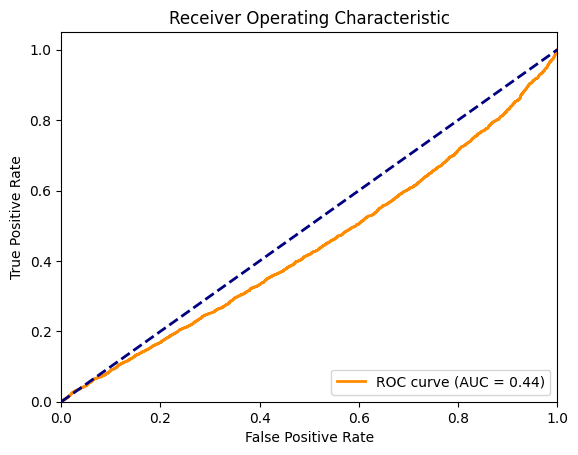

Test AUC: 0.44


In [ ]:
from sklearn.metrics import roc_curve, auc

# Plot the ROC curve and calculate AUC
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

roc_auc = plot_roc_curve(true_labels, similarity_scores)
print("Test AUC: {:.2f}".format(roc_auc))